In [1]:
import astroFuncs as af

#required for pipeline data processing
import numpy as np
from sklearn import preprocessing
import pickle
spec_z_model = pickle.load(open('/home/richard/work_placement/CNGFPPR/ml_model/ps_spec_model.sav', 'rb'))


HELLLEDFOFOPSEIFJOSIHNERF


In [2]:
af.mastcasjobs_init()

Enter Casjobs username: richardon
Enter Casjobs password: ········


In [3]:
def remove_invalid(df):
    df = df.query("rKronMag != -999 &\
                    rPSFMag != -999 &\
                    rKronMagErr != -999 &\
                    rPSFMagErr != -999")
    return df


def remove_out_of_range(df):
    lwr_ext_maglim = 17
    upr_ext_maglim = 20
    df = df.query("rPSFMag >= @lwr_ext_maglim &\
                   rPSFMag <= @upr_ext_maglim")
    return df


def drop_dupes_non_primary_detections(df):
    """
    In PS1 query primary detections are taken by default
    """
    df = df.sort_values(by="nDetections", ascending=False, kind="stable")
    df["isDupe"] = df.duplicated("objID", keep="first")
    df = df.query("isDupe == False")
    return df


def get_extended(df):
    nSigmaConf = 5
    df["Extended"] = np.where(
         (df.rExtNSigma > nSigmaConf) & (df.gExtNSigma > nSigmaConf),
         True, False)
    df = df.query("Extended == True")
    df = df.drop(["Extended", "isDupe"], axis=1).reset_index(drop=True)
    return df


def make_nan(df):
    return df.replace(-999, np.nan)


def pipe_step1(df):
    return (df
           .pipe(remove_invalid)
           .pipe(remove_out_of_range)
           .pipe(drop_dupes_non_primary_detections)
           .pipe(get_extended)
           .pipe(make_nan))

In [4]:
a, b, c = 0.99504614, -30.94434771, 245.40805416

def get_star_mask(x):
    mask_px = (a*x**2 + b*x + c)
    mask_deg = mask_px / (4 * 60 * 60)
    return mask_deg



def mask_bright_stars(df, ra, dec, rad):
    bright_stars = af.search_bright_stars(ra, dec, rad)
    
    if bright_stars is None:
        return df
    
    else:
        bright_stars = bright_stars[bright_stars['Vmag'].notna()]
        bright_stars = bright_stars.query("Vmag < 15").reset_index(drop=True)
        
        bright_stars["mask_deg"] = get_star_mask(bright_stars.Vmag)
        
        ralist = df.raMean
        declist = df.decMean
        
        for index, row in bright_stars.iterrows():
            star_ra = row.RA
            star_dec = row.Dec
            mask = row.mask_deg
            
            to_drop = af.proximity_search(ralist, declist, [star_ra, star_dec], mask)
            
            ralist = ralist.drop(to_drop).reset_index(drop=True)
            declist = declist.drop(to_drop).reset_index(drop=True)
            df = df.drop(to_drop).reset_index(drop=True)
            
        return df

In [5]:
def mask_galaxies(df, ra, dec, rad):
    gals = af.search_hleda(ra, dec, rad)
    
    if len(gals) == 0:
        return df
    
    else:
        gals.PA = gals.PA.fillna(0)
        gals = gals[gals.semi_major.notna()].reset_index(drop=True)
        
        ralist = df.raMean
        declist = df.decMean
        
        for index, row in gals.iterrows():
            gal_ra = row.RA
            gal_dec = row.DEC
            semi_major = row.semi_major
            semi_minor = row.semi_minor
            angle = row.PA
            
            in_gal = af.check_in_ellipse(ralist, declist, gal_ra, gal_dec,
                                         semi_major, semi_minor, angle)
            
            to_drop = in_gal.nonzero()[0]
            
            ralist = ralist.drop(to_drop).reset_index(drop=True)
            declist = declist.drop(to_drop).reset_index(drop=True)
            df = df.drop(to_drop).reset_index(drop=True)
        
        return df

In [6]:
def PS_features(df):
    #creating colour features
    df["gr_PS"] = df.gKronMag - df.rKronMag
    df["ri_PS"] = df.rKronMag - df.iKronMag
    df["iz_PS"] = df.iKronMag - df.zKronMag
    df["zy_PS"] = df.zKronMag - df.yKronMag
    #normalising rMag
    df["rMagNormPS"] = preprocessing.scale(df.rKronMag.values)
    #normalising colour data
    df["grNormPS"] = preprocessing.scale(df.gr_PS.values)
    df["riNormPS"] = preprocessing.scale(df.ri_PS.values)
    df["izNormPS"] = preprocessing.scale(df.iz_PS.values)
    df["zyNormPS"] = preprocessing.scale(df.zy_PS.values)
    return df

def get_test_data(df):
    return df[['rMagNormPS', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS']]

#### Functions Useful for CDES, CDFS

In [95]:
def check_in_roi(cdes, zgrid, max_z, prob, prob_upr=1):
    inds = list()
    bin_width = 1/len(zgrid)
    cde_ind_lim = int(len(zgrid) * max_z)
    for ind, cde in enumerate(cdes):
        val = cde[:cde_ind_lim].sum()
        sumcde = (val * bin_width)
        if sumcde>prob and sumcde<=prob_upr:
            inds.append(ind)
    return inds

def get_prob_range(cdes, zgrid, min_z, max_z):
    probs = list()
    len_z = len(zgrid)
    bin_width = 1/len_z
    cde_ind_zmax = int(len_z * max_z)
    cde_ind_zmin = int(len_z * min_z)
    for ind, cde in enumerate(cdes):
        val = cde[cde_ind_zmin:cde_ind_zmax].sum()
        sumcde = (val * bin_width)
        probs.append(sumcde)
    return probs

def plot_cdes(cdes, zgrid, shape, start=0, figsize=(12,12), marker=None):
    nrows = shape[0]
    ncols = shape[1]
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    #could be issue here where will not flatten if 1 axs needed only
    axs = axs.flatten()
    for i in range(start, (nrows*ncols)+start):
        # axs[i].plot(zgrid, cdes[candidates_ind[i]])
        axs[i-start].plot(zgrid, cdes[i])
        if marker is not None:
            axs[i-start].axvline(marker, color="red", alpha=0.5)
    plt.show()


def get_cdfs(cdes, zgrid):
    cdfs = np.zeros((len(cdes), len(zgrid)))
    for ind, cde in enumerate(cdes):
        cumsum=0
        for i, val in enumerate(cde):
            cumsum += val
            cdfs[ind,i] = cumsum 
    return cdfs

# Running the Pipeline

In [2]:
ra = 40
dec = 40
rad = 1
tablename = "CNGFPPR_testrun"

In [29]:
# unprocessed_df = af.search_circ_region(ra, dec, rad, table_name=tablename)
unprocessed_df = af.retrieve_table(tablename)

### Data Vis

In [34]:
# for visualisation of masking stars and galaxies, not needed for pipeline
stars_test = af.search_bright_stars(ra, dec, rad)
gals_test = af.search_hleda(ra, dec, rad)

In [35]:
stars_test = stars_test[stars_test['Vmag'].notna()]
stars_test = stars_test.query("Vmag < 15").reset_index(drop=True)
gals_test = gals_test[gals_test.semi_major.notna()].reset_index(drop=True)

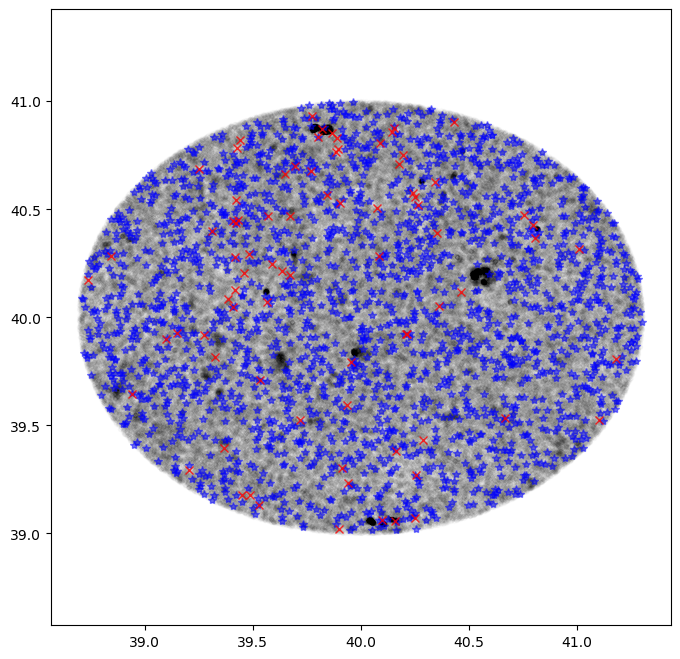

In [65]:
#peek at the data
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=[8,8])
axs.axis("equal")

plt.plot(unprocessed_df.raMean, unprocessed_df.decMean, ".k", alpha=0.01)

plt.plot(stars_test.RA, stars_test.Dec, "b*", alpha=0.5)

plt.plot(gals_test.RA, gals_test.DEC, "rx", alpha=0.8)


plt.show()

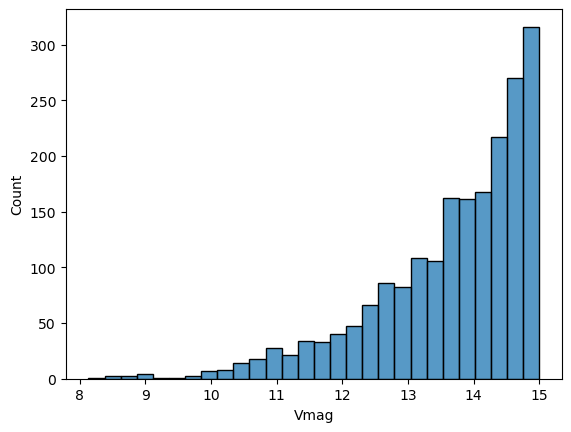

In [67]:
sns.histplot(stars_test.Vmag)
plt.show()

### Getting Valid Sources
#### Removing Point Sources

In [57]:
extended_sources = unprocessed_df.pipe(pipe_step1)

In [58]:
len(extended_sources)

1457

#### Masking

In [59]:
extended_sources_star_mask = extended_sources.pipe(mask_bright_stars, ra=ra, dec=dec, rad=rad)

In [60]:
len(extended_sources_star_mask)

1456

In [61]:
extended_sources_star_gal_mask = extended_sources_star_mask.pipe(mask_galaxies,
                                                                ra=ra, dec=dec, rad=rad)

In [62]:
len(extended_sources_star_gal_mask)

1337

#### ML PreProcessing

In [72]:
procesed_data = extended_sources_star_gal_mask.pipe(PS_features)

In [73]:
procesed_test_data = procesed_data.pipe(get_test_data)

In [86]:
n_grid = 1000
cdes, zgrid = spec_z_model.predict(procesed_test_data, n_grid=n_grid)

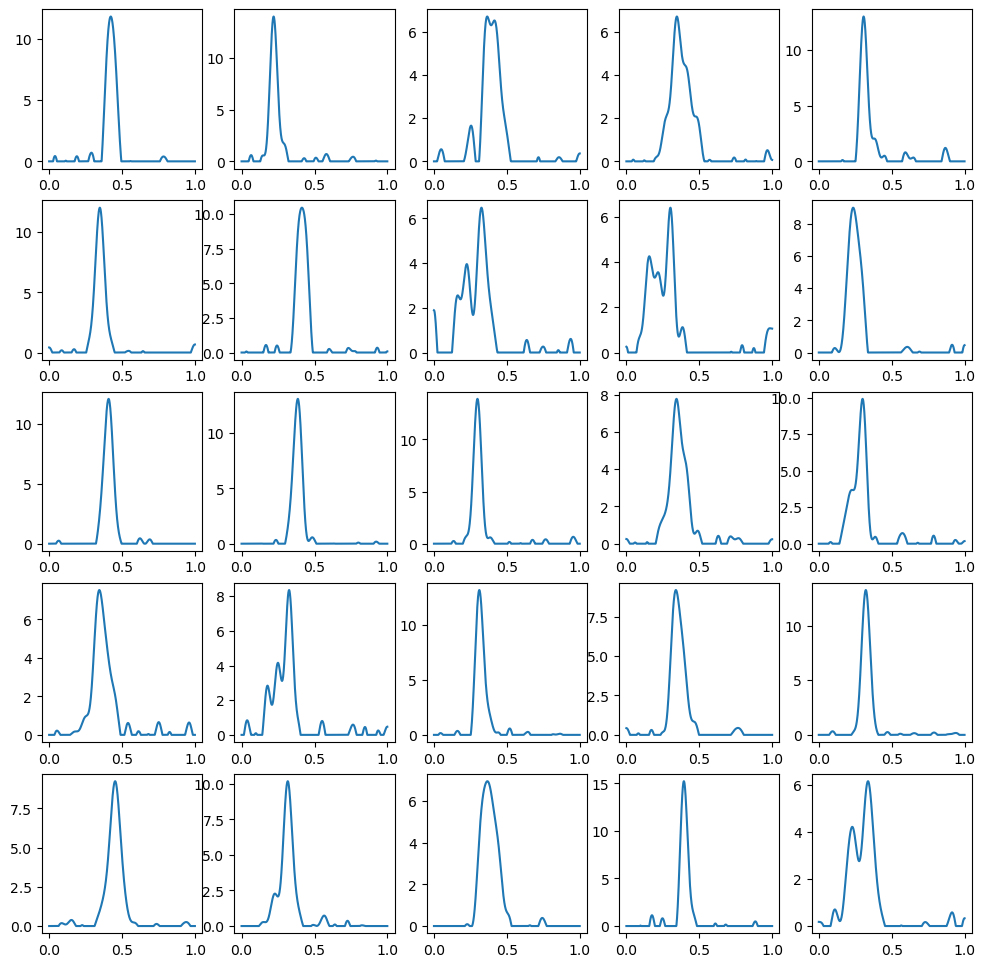

In [97]:
plot_cdes(cdes, zgrid, start=3, shape=(5,5))

In [98]:
1456-1337

119